In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
local_dir_path = os.path.dirname('Downloads')
data_dir = os.path.join(local_dir_path, "traintestface")
print(data_dir)

traintestface


In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

260


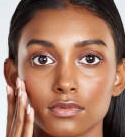

In [5]:
normal_skin = list(data_dir.glob('normal skin/*'))
PIL.Image.open(str(normal_skin[0]))

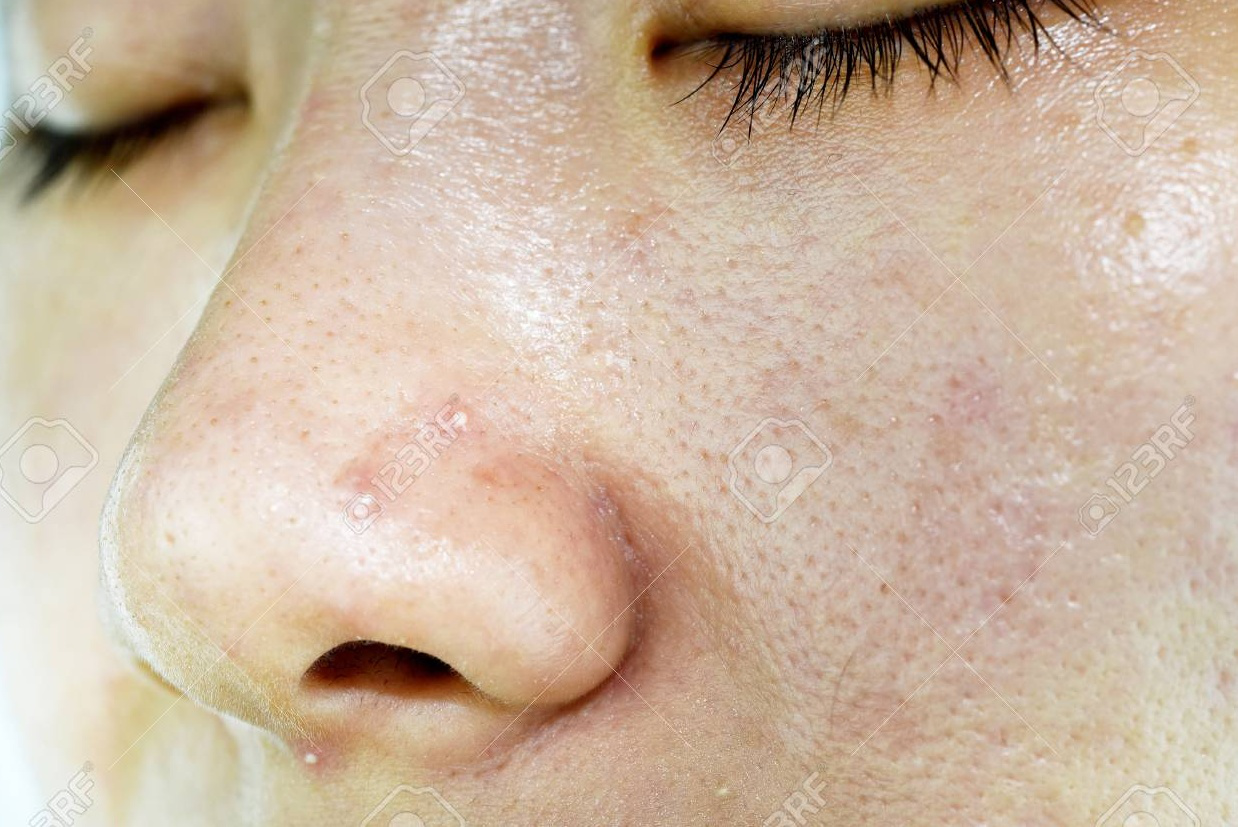

In [6]:
oily_skin= list(data_dir.glob('oily skin/*'))
PIL.Image.open(str(oily_skin[0]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 3 classes.
Using 208 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 3 classes.
Using 52 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'normal skin', 'oily skin']


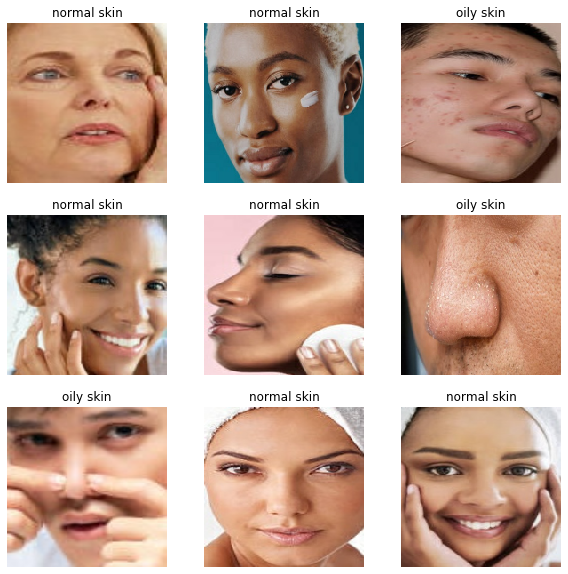

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE =tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9851404


In [16]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

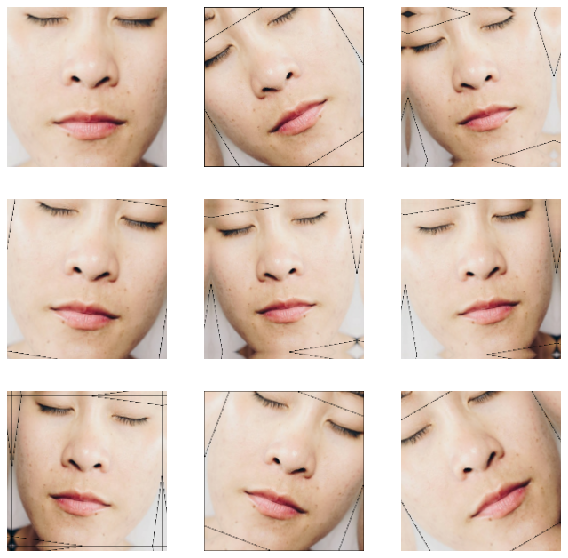

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
num_classes=5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/500
7/7 [==============================] - 3s 470ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.5087 - val_accuracy: 0.8846
Epoch 2/500
7/7 [==============================] - 3s 471ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5929 - val_accuracy: 0.8654
Epoch 3/500
7/7 [==============================] - 3s 460ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5893 - val_accuracy: 0.8846
Epoch 4/500
7/7 [==============================] - 3s 482ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.5845 - val_accuracy: 0.8654
Epoch 5/500
7/7 [==============================] - 3s 467ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.5931 - val_accuracy: 0.8654
Epoch 6/500
7/7 [==============================] - 3s 461ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6692 - val_accuracy: 0.8269
Epoch 7/500
7/7 [==============================] - 3s 459ms/step - loss: 5.1653e-04 - accuracy: 1.0000 - val_loss: 0.6858 - val_accuracy: 0.8462
Epoch 8/5

KeyboardInterrupt: 

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [21]:
model=keras.models.load_model('model.h5')
import datetime

In [22]:
log_dir="logs/fit"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

ls my_model

In [23]:
image_paths=['outside_pics/oilyc1.jpeg','outside_pics/normalc1.jpeg']
for i in image_paths:
    img = keras.preprocessing.image.load_img(i, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(i,"Your Face is most likely belongs to {} with a {:.2f} percent confidence.\n".format(class_names[np.argmax(score)], 100 * np.max(score)))
    if class_names[np.argmax(score)]=='oily skin':
        print("you can choose these recommended facewashes :)\n")
        h = open("oily skin facewashes.txt", "r")
        for line in h:
            print (line)
        h.close()
    elif class_names[np.argmax(score)]=='normal skin':
        print("you can choose these recommended face washes :)\n")
        h = open("normal skin fashwashes.txt", "r")
        for line in h:
            print (line)
        h.close()

outside_pics/oilyc1.jpeg Your Face is most likely belongs to oily skin with a 99.99 percent confidence.

you can choose these recommended facewashes :)

Plum Green Tea Pore Cleansing Face Wash

Biotique BIO Honey Gel Face Wash 

Natural Vibes ~ Ayurvedic Tea Tree Face Wash

Forest Essentials Mashobra Honey, Lemon and Rosewater Facial Cleanser

outside_pics/normalc1.jpeg Your Face is most likely belongs to normal skin with a 99.93 percent confidence.

you can choose these recommended face washes :)

Himalaya Herbals Purifying Neem Face Wash	

Neutrogena Deep Clean Facial Cleanser	

St. Botanica Vitamin C Gentle Foaming Brightening Face Wash

Mcaffeine Neem Face Wash	

Pondâ€™s Pure White Anti-Pollution + Purity Face Wash	

Clean & Clear Foaming Face Wash	

Aroma Magic Neem And Tea Tree Face Wash	

Lotus Herbals Tea Tree And Cinnamon Anti-Acne Oil Control Face Wash	

Greenberry Organics Detox Charcoal Face Wash	

Himalaya Herbals Purifying Neem Foaming Face Wash

Plum Green Tea Pore Clea

In [3]:
%load_ext tensorboard

In [24]:
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553467904/553467096 [==============================] - 93s 0us/step


In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = 'outside_pics/oilyc1.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = model.predict(x)


574717952/574710816 [==============================] - 93s 0us/step


In [27]:
block4_pool_features

array([[[[ 149.29723 ,  464.42725 ,  787.3164  , ...,    0.      ,
           717.09076 ,   88.2357  ],
         [   0.      ,    0.      ,  493.15863 , ...,    0.      ,
           801.80414 ,  390.92224 ],
         [   0.      ,    0.      ,  270.76132 , ...,    0.      ,
             0.      ,  482.59332 ],
         ...,
         [   0.      ,    0.      ,   45.743656, ...,    0.      ,
             0.      ,  265.5281  ],
         [ 222.93414 ,  206.70287 ,   22.190617, ...,    0.      ,
             0.      ,  281.23343 ],
         [ 387.80945 ,    0.      ,    0.      , ...,    0.      ,
             0.      ,    0.      ]],

        [[   0.      ,    0.      ,  749.3523  , ...,    0.      ,
            42.724194,   67.61954 ],
         [   0.      ,    0.      ,  123.08856 , ...,    0.      ,
             0.      ,    0.      ],
         [   0.      ,    0.      ,    0.      , ...,    0.      ,
             0.      ,    0.      ],
         ...,
         [   0.      ,   64.85261 

In [28]:
score = tf.nn.softmax(block4_pool_features[0])

In [29]:
score

<tf.Tensor: shape=(14, 14, 512), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0.,

In [30]:
print(i,"Your Face is most likely belongs to {} with a {:.2f} percent confidence.\n".format(class_names[np.argmax(score)], 100 * np.max(score)))
if class_names[np.argmax(score)]=='oily skin':
    print("you can choose these recommended facewashes :)\n")
    h = open("oily skin facewashes.txt", "r")
    for line in h:
        print (line)
    h.close()
elif class_names[np.argmax(score)]=='normal skin':
    print("you can choose these recommended face washes :)\n")
    h = open("normal skin fashwashes.txt", "r")
    for line in h:
        print (line)
    h.close()

IndexError: list index out of range